In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [13]:
plt.style.use('seaborn-v0_8')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='small',
    
)

In [22]:
store_sales = pd.read_csv(
    '../resources/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    parse_dates=['date']
)

store_sales['date'] = store_sales.date.dt.to_period('D')

store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
display(store_sales.head())
family_sales = store_sales.groupby(['family', 'date']).mean().unstack('family').loc['2017']
display(family_sales.head())

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

sales            ...                onpromotion          
family     AUTOMOTIVE BABY CARE  ... SCHOOL AND OFFICE SUPPLIES   SEAFOOD
date                             ...                                     
2017-01-01   0.092593  0.037037  ...                        0.0  0.000000
2017-01-02  11.481481  0.259259  ...                        0.0  0.407407
2017-01-03   8.296296  0.296296  ...                        0.0  0.407407
2017-01-04   6.833333  0.333333  ...                        0.0  0.333333
2017-01-05   6.333333  0.351852  ...                        0.0  0.444444

[5 rows x 66 columns]

In [28]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns= y.columns
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        self.model_2.fit(X_2, y_resid)
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long
    
        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        
        return y_pred.unstack()  # long to wide

    

In [40]:
display(family_sales.head())

# Target series
y = family_sales.loc[:, 'sales']

display(y.head())

# # X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()
display(X_1.head())

# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature
display(X_2)

# # Label encoding for 'family'
X_2 = X_2.reset_index(level='family')
display(X_2.head())

# sklearn.preprocessing.LabelEncoder.fit_transform acts like pd.Series.factorize 
# they accept a Series of category-like data and assign an unique value to each category
le = LabelEncoder()  # from sklearn.preprocessing
X_2['family'] = le.fit_transform(X_2['family'])
display(X_2.head())


# # Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

display(X_2.head())

sales            ...                onpromotion          
family     AUTOMOTIVE BABY CARE  ... SCHOOL AND OFFICE SUPPLIES   SEAFOOD
date                             ...                                     
2017-01-01   0.092593  0.037037  ...                        0.0  0.000000
2017-01-02  11.481481  0.259259  ...                        0.0  0.407407
2017-01-03   8.296296  0.296296  ...                        0.0  0.407407
2017-01-04   6.833333  0.333333  ...                        0.0  0.333333
2017-01-05   6.333333  0.351852  ...                        0.0  0.444444

[5 rows x 66 columns]

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222222,0.000000,9.084685,0.129630,7.500000,11.518519,3.629167,1.907407,14.388889,37.000000,0.314815,0.000000,0.814815,0.296296,0.000000,2.574074,0.000000,0.592593,0.055556,16.203704,0.074074,5.013167,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481481,0.259259,11.648148,6208.055556,0.481481,844.836296,14.203704,2233.648148,1545.000000,539.114833,348.074074,221.853555,7688.573148,34.833333,2.037037,54.759259,35.925926,0.740741,605.981481,24.111111,13.074074,10.277778,92.425926,7.777778,488.522332,714.370370,12.814815,22.777778,581.413130,153.555538,3409.500535,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814815,0.814815,665.124111,10.629630,1711.907407,1204.203704,404.300074,247.111111,166.614908,5946.023370,23.759259,1.333333,42.425926,27.314815,0.462963,432.407407,11.629630,11.462963,8.351852,58.629630,3.500000,427.520909,488.333333,8.870370,13.555556,462.013665,125.820537,3394.559756,2.018519,27.135259
2017-01-04,6.833333,0.333333,6.888889,3911.833333,0.759259,594.160611,11.185185,1508.037037,1107.796296,309.397685,204.870370,171.411074,5077.233241,23.166667,1.277778,44.833333,25.648148,0.574074,375.296296,10.777778,14.962963,8.000000,61.148148,3.500000,369.121482,426.574074,8.129630,12.092593,431.276409,116.740815,3467.447956,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796296,0.407407,495.511611,12.444444,1241.833333,829.277778,260.776500,166.740741,128.944185,4201.170019,19.037037,0.888889,49.759259,22.870370,0.407407,315.370370,9.666667,13.055556,7.092593,64.222222,3.203704,368.945687,360.925926,7.629630,10.333333,345.673499,101.434574,2069.316630,1.425926,20.615333


,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0


onpromotion
date       family                                 
2017-01-01 AUTOMOTIVE                     0.000000
           BABY CARE                      0.000000
           BEAUTY                         0.000000
           BEVERAGES                      0.703704
           BOOKS                          0.000000
...                                            ...
2017-08-15 POULTRY                        0.111111
           PREPARED FOODS                 0.166667
           PRODUCE                       58.685185
           SCHOOL AND OFFICE SUPPLIES     2.740741
           SEAFOOD                        0.000000

[7491 rows x 1 columns]

,family,onpromotion
date,,
2017-01-01,AUTOMOTIVE,0.000000
2017-01-01,BABY CARE,0.000000
2017-01-01,BEAUTY,0.000000
2017-01-01,BEVERAGES,0.703704
2017-01-01,BOOKS,0.000000


,family,onpromotion
date,,
2017-01-01,0,0.000000
2017-01-01,1,0.000000
2017-01-01,2,0.000000
2017-01-01,3,0.703704
2017-01-01,4,0.000000


,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


In [45]:
model = BoostedHybrid(model_1=LinearRegression(), model_2=XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(lower=0.0)



/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_6928/106537499.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  y_pred.loc(axis=1)['AUTOMOTIVE', 'BEAUTY'].plot(


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

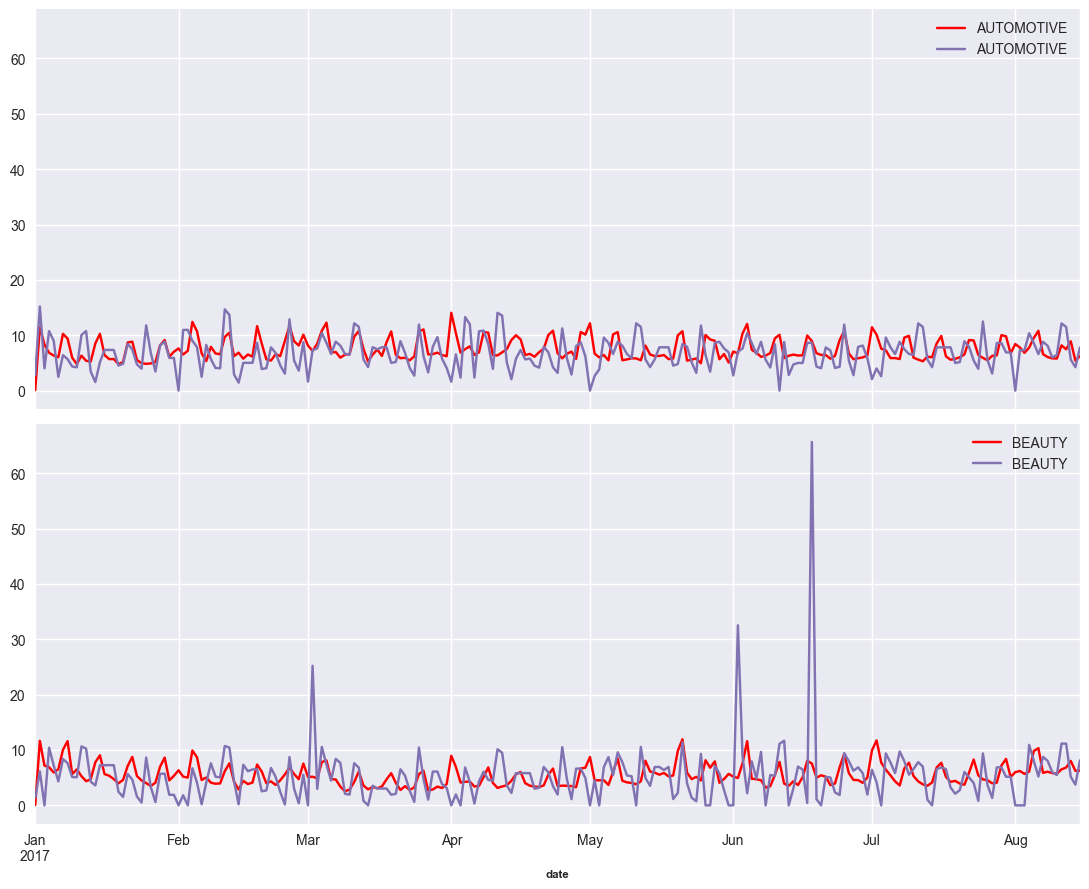

In [59]:
axs = y.loc(axis=1)['AUTOMOTIVE', 'BEAUTY'].plot(
    subplots=True,
    sharex=True,
    sharey=True,
    color='red',
    figsize=(11,9)
)
y_pred.loc(axis=1)['AUTOMOTIVE', 'BEAUTY'].plot(
    subplots=True,
    sharex=True,
    color='C3',
    ax=axs
)